# Custom modules

In [1]:
import os
import sys
# Custom modules: add the 'lib' directory as one where we can import modules
# lib_src = os.path.join(os.getcwd(), os.pardir, 'src')
lib_src = '../../machine-learning'
sys.path.insert(1, lib_src)

from model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split, sample_report, split_report, sample_split_report
from dummies import reverse_dummies, get_dummies_indices
from size import size

# Standard data science modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

# Loading data

Sign up for an account on [DrivenData](http://www.drivendata.org/)  
Join the [Box-plots for education competition](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/)  
Download the competition datasets named `TrainingData.csv` and `TestData.csv`

In [3]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

# Shuffling data

In machine learning theory, i.i.d. assumption is often made for training datasets to imply that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

To ensure observations are independent and don't follow any predefined sequence, the dataset is shuffled.

That's important when using the class `sklearn.model_selection.GridSearchCV` with k-fold cross-validation which doesn't resample the dataset as per the underlying class `sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)` doesn't shuffle data by default and that could lead to biased folds.

In [4]:
df = df.sample(frac=1, replace=False, random_state=1)

# Encoding labels as category types

In [5]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
print('Memory before enconding: {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))

Memory before enconding: 79.4 MiB (548.5 MiB deep)
Memory after enconding : 55.4 MiB (313.0 MiB deep)


# Frequency of label classes

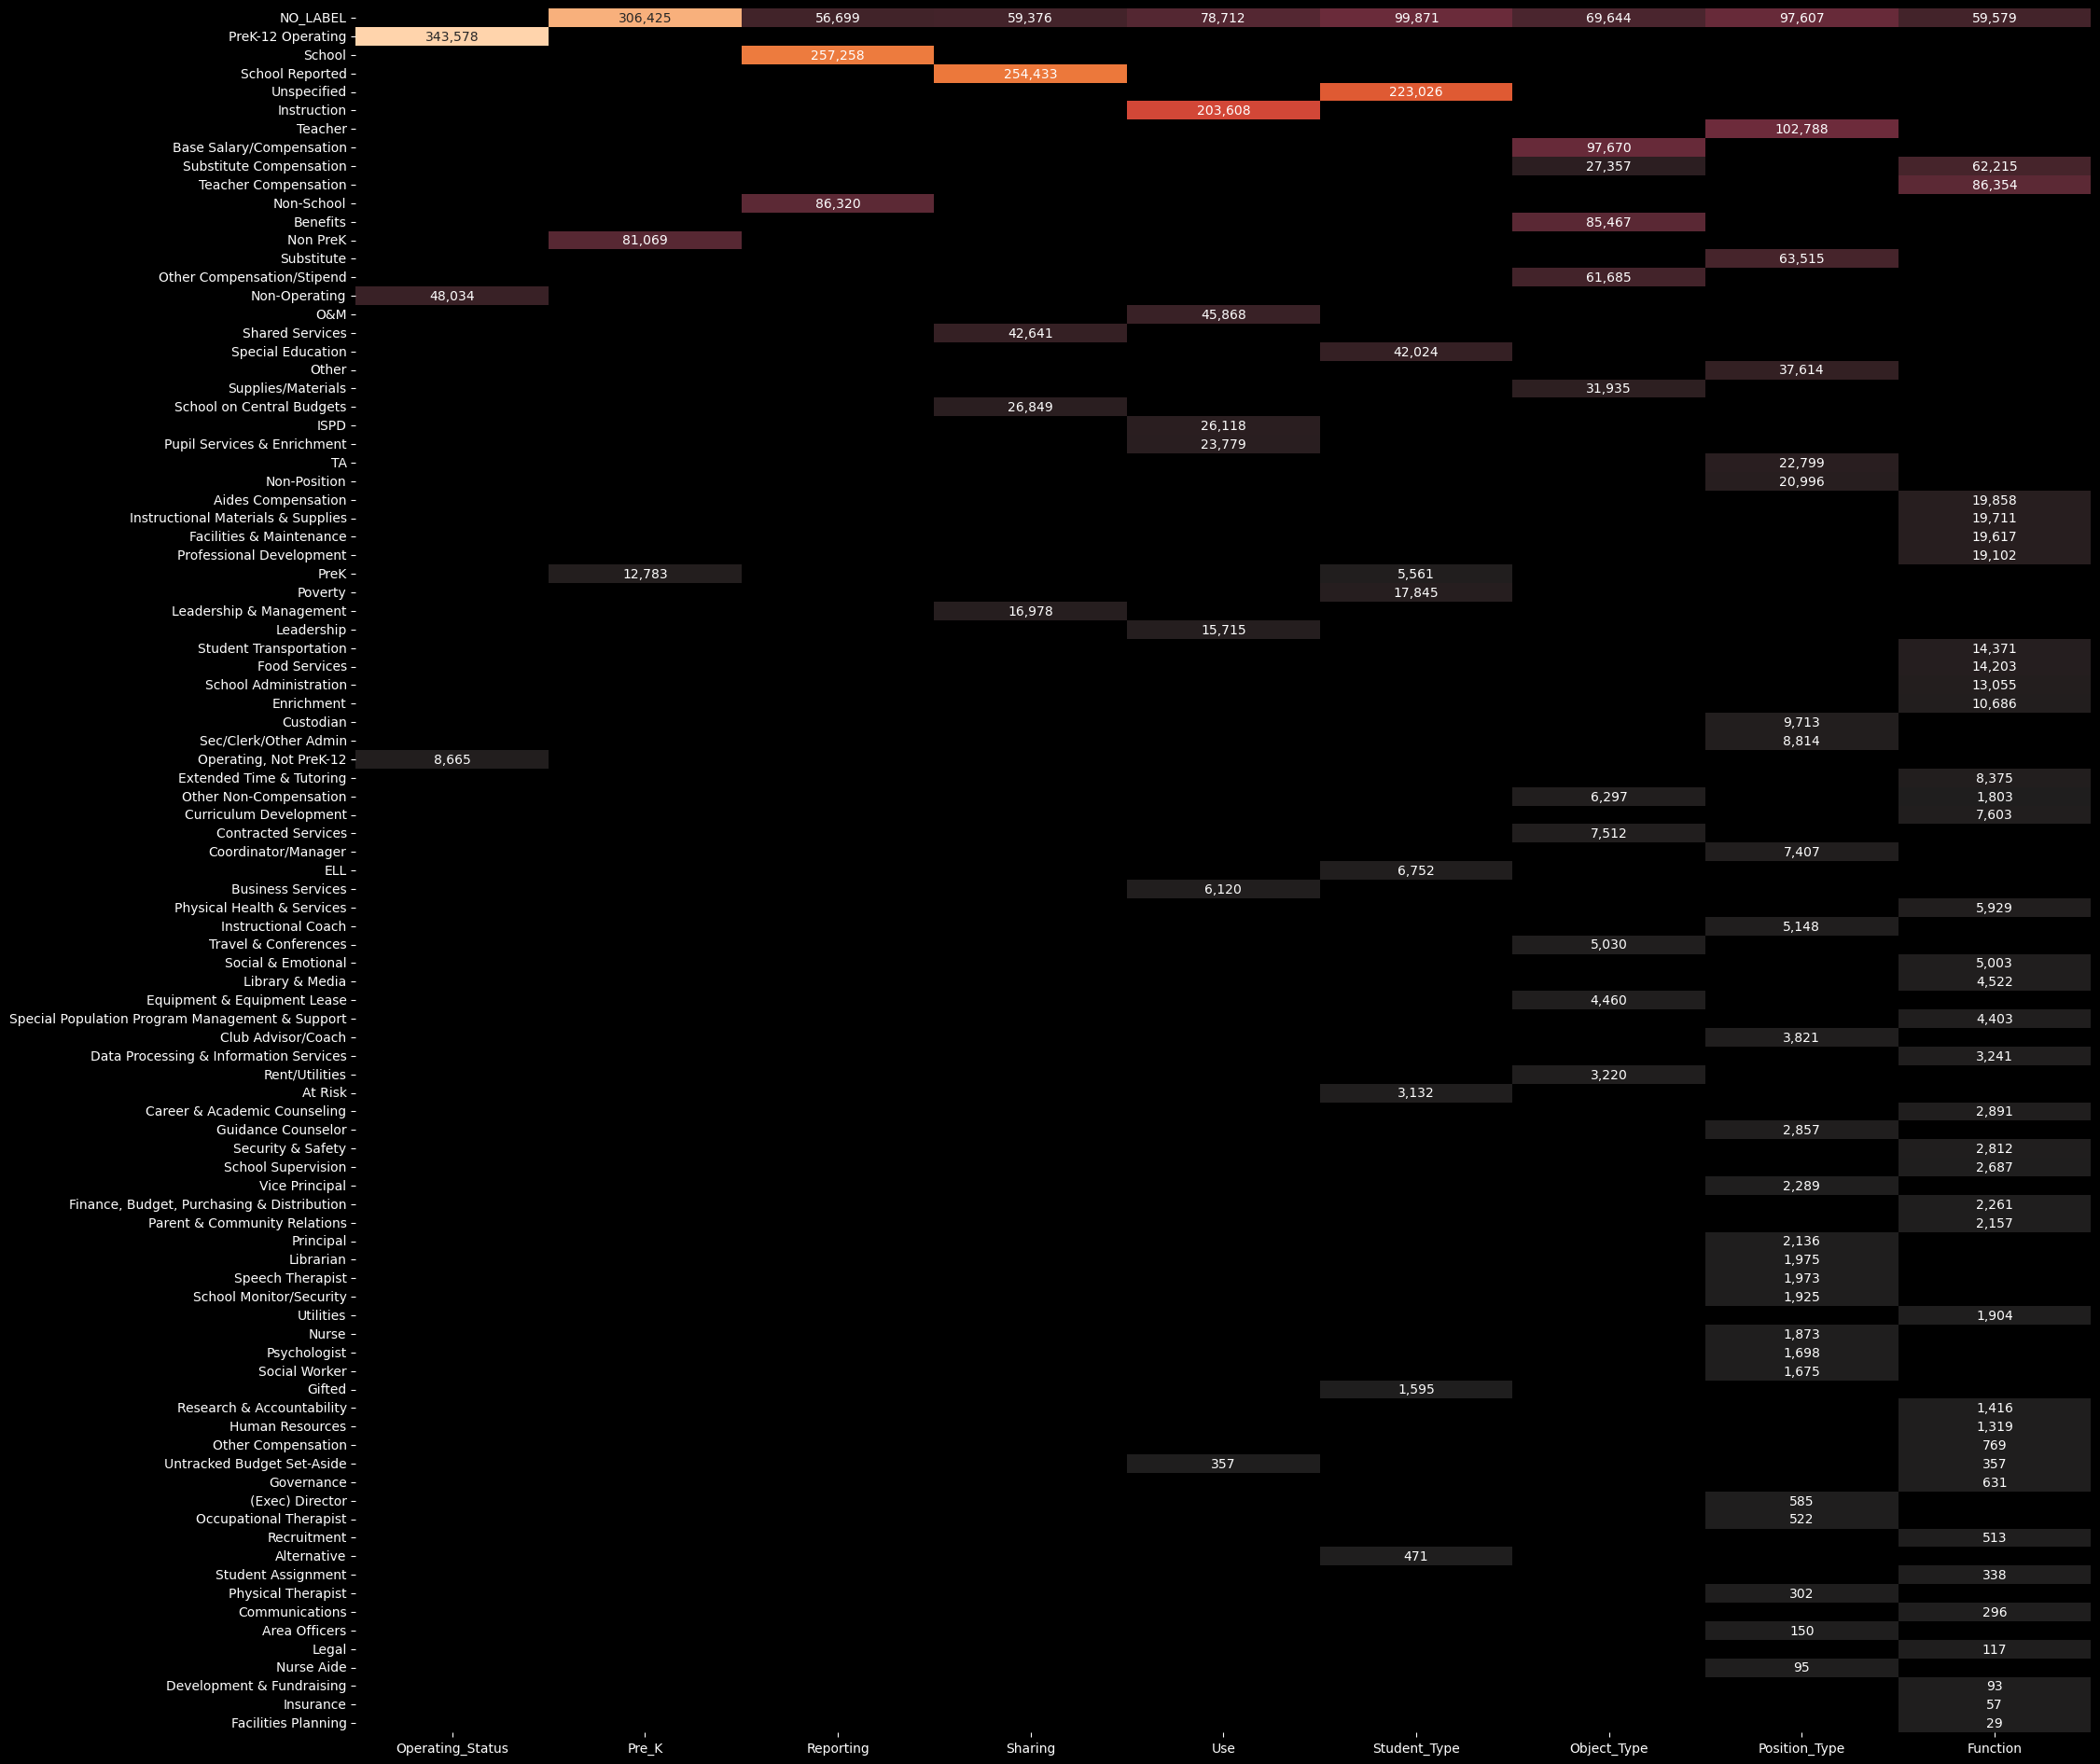

In [82]:
col_idx = df[LABELS].apply(lambda x: x.value_counts()).count().sort_values(ascending=True).index
row_idx = df[LABELS].apply(lambda x: x.value_counts()).sum(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(24,24))
sns.heatmap(df[col_idx].apply(lambda x: x.value_counts()).loc[row_idx], annot=True, fmt=',.0f', center=0, cbar=False)
plt.show()

In [22]:
df[LABELS].value_counts().to_frame('value_counts')

value_counts
Function                   Object_Type                Operating_Status  Position_Type         Pre_K    Reporting  Sharing                 Student_Type Use                                      
NO_LABEL                   NO_LABEL                   Non-Operating     NO_LABEL              NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL     NO_LABEL                            48034
Teacher Compensation       Benefits                   PreK-12 Operating Teacher               NO_LABEL School     School Reported         Unspecified  Instruction                         22169
Substitute Compensation    Base Salary/Compensation   PreK-12 Operating Substitute            NO_LABEL School     School Reported         Unspecified  Instruction                         16130
                           Benefits                   PreK-12 Operating Substitute            NO_LABEL School     School Reported         Unspecified  Instruction                         14110
Teacher Compensation       Base Salary/Compensation   PreK-12 Operating Teacher               NO_LABEL School     School Reported         Unspecified  Instruction                         13551
...                                                                                                                                                                                          ...
Physical Health & Services Other Compensation/Stipend PreK-12 Operating Non-Position          Non PreK Non-School Leadership & Management Unspecified  Pupil Services & Enrichment             1
                                                                        Instructional Coach   NO_LABEL Non-School Shared Services         Unspecified  Pupil Services & Enrichment             1
                                                                        Coordinator/Manager   NO_LABEL Non-School Shared Services         Unspecified  Pupil Services & Enrichment             1
                           NO_LABEL                   PreK-12 Operating Sec/Clerk/Other Admin NO_LABEL Non-School NO_LABEL                NO_LABEL     NO_LABEL                                1
Utilities                  Supplies/Materials         PreK-12 Operating Non-Position          NO_LABEL Non-School Shared Services         Unspecified  O&M                                     1

[5489 rows x 1 columns]

# Converting labels in dummy variables

In [34]:
# Converting labels in dummy variables
y = pd.get_dummies(df[LABELS], prefix_sep='__')
y.info(memory_usage='deep')
y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 129752 to 189020
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 42.8 MB


,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
129752,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
127683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
265931,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
238935,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
253483,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


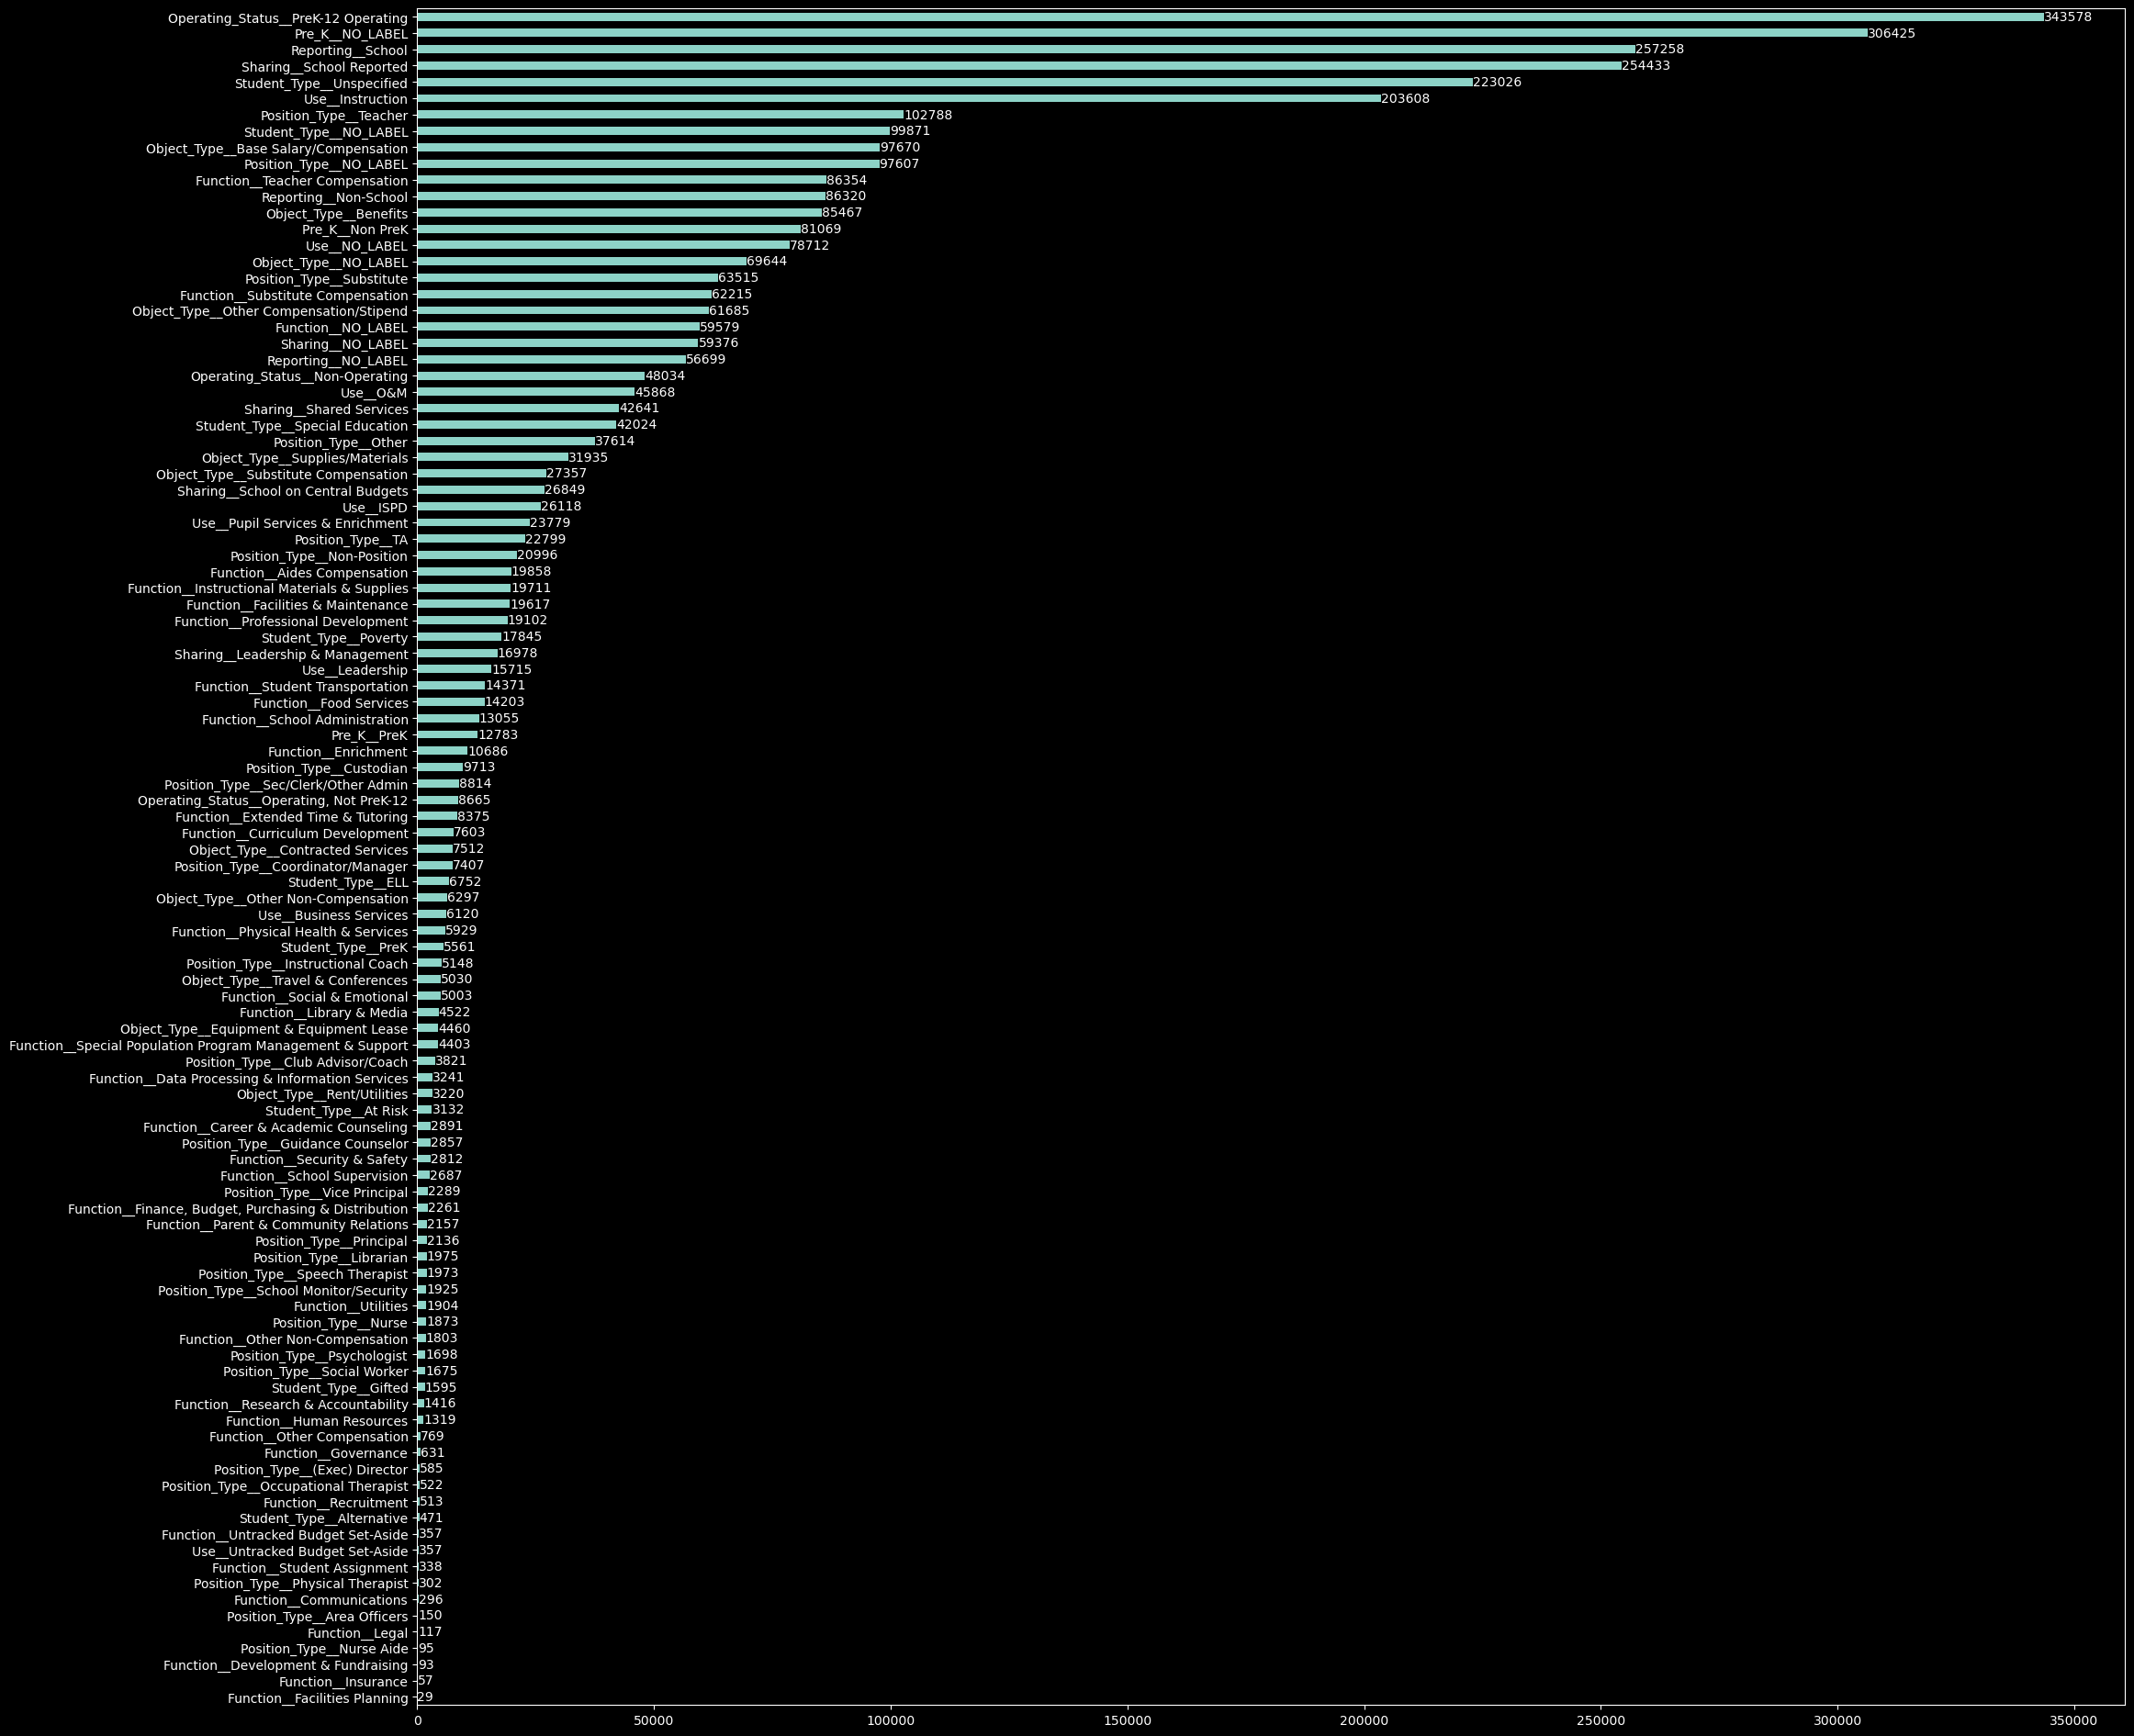

In [84]:
plt.figure(figsize=(24,24))
ax = y.sum().sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.show()

# Number of classes (ones)

In [86]:
y.sum().sum()

3602493

# Test 0: Imbalanced 90/10 sample using sklearn's train_test_split()

Train size: 360249
Test size : 40028


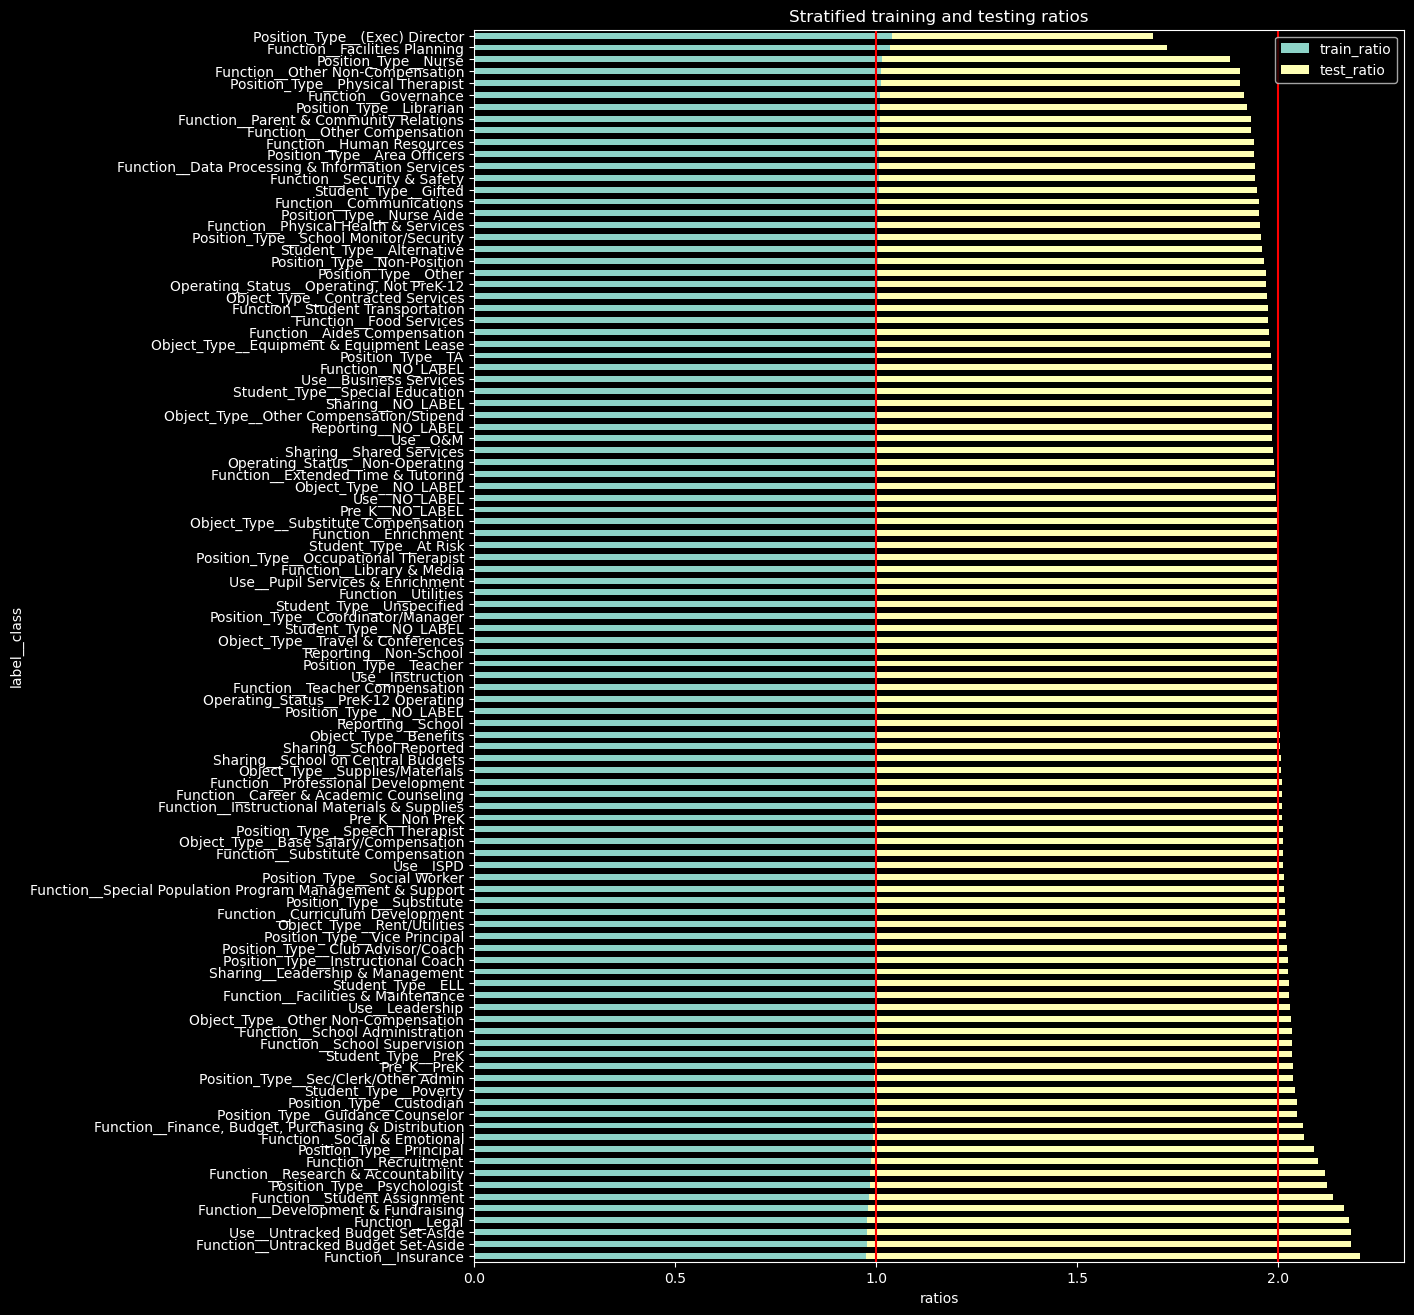

,train_ratio,test_ratio
label__class,,
Position_Type__(Exec) Director,1.038937,0.649568
Function__Facilities Planning,1.034484,0.689650
Position_Type__Nurse,1.015009,0.864916
Function__Other Non-Compensation,1.011895,0.892949
Position_Type__Physical Therapist,1.011774,0.894033
...,...,...
Function__Development & Fundraising,0.979690,1.182787
Function__Legal,0.978158,1.196572
Function__Untracked Budget Set-Aside,0.977281,1.204473


In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = 0.1, random_state=1, stratify=None)
print('Train size:', y_train.shape[0])
print('Test size :', y_test.shape[0])
split_report(y, y_train, y_test, figsize=(12,16))

# Test 1: trying to stratify labels using sklearn's train_test_split()

In [129]:
from sklearn.model_selection import train_test_split
try:
    X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = 0.1, random_state=1, stratify=y)
except ValueError as err:
    print('ValueError:', err)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


As pointed out in **_Groups of labels with less than 2 samples (unstratifiable)_**, the y population has class groups with less than 2 observations, thefore, the standard sklearn's `train_test_split()` won't work because of those cases.

# Test 2: Stratifying 90/10 sample using multi_train_test_split()

Train size: 360250
Test size : 40027


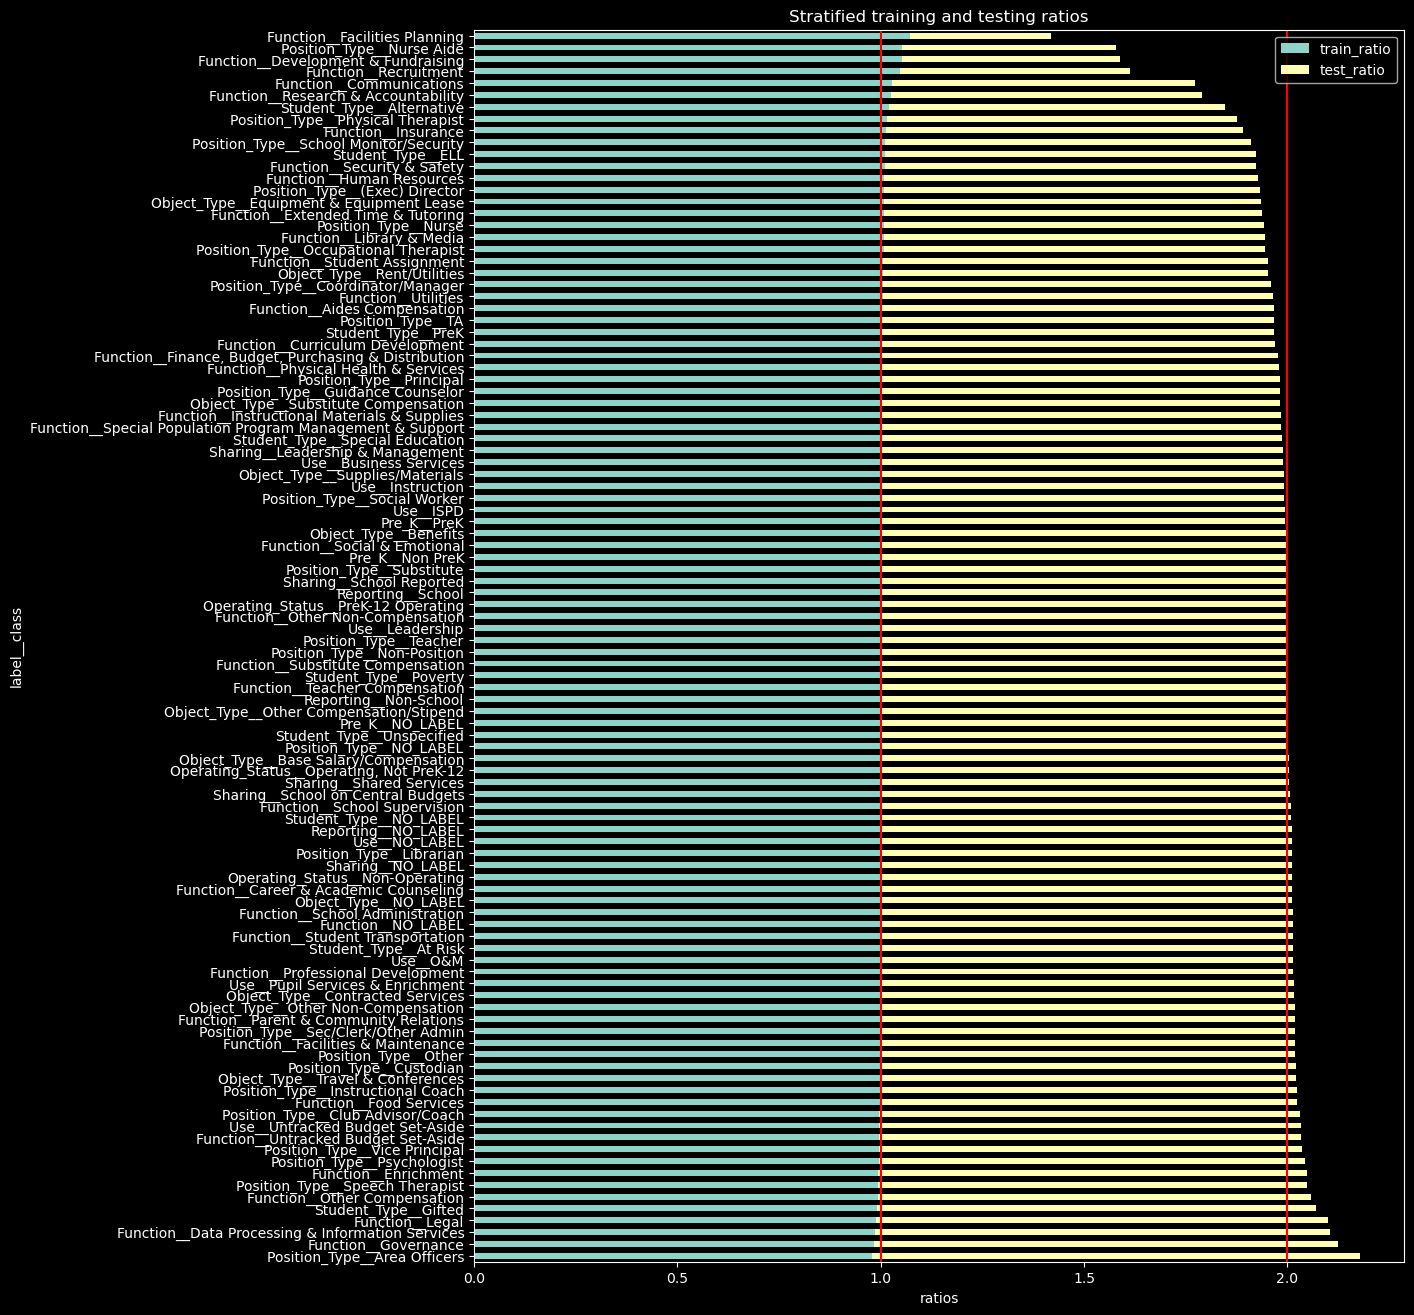

,train_ratio,test_ratio
label__class,,
Function__Facilities Planning,1.072795,0.344834
Position_Type__Nurse Aide,1.052630,0.526325
Function__Development & Fundraising,1.051372,0.537644
Function__Recruitment,1.048298,0.565312
Function__Communications,1.028527,0.743256
...,...,...
Student_Type__Gifted,0.991290,1.078389
Function__Legal,0.987652,1.111131
Function__Data Processing & Information Services,0.987005,1.116959


In [133]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], y, size=0.1, min_count=0, seed=1)
print('Train size:', y_train.shape[0])
print('Test size :', y_test.shape[0])
split_report(y, y_train, y_test, figsize=(12,16))

# Test 3: Stratifying 90/10 sample of a strafied 90/10 sample using multi_train_test_split()

## Stratified sample

Sample size: 40027


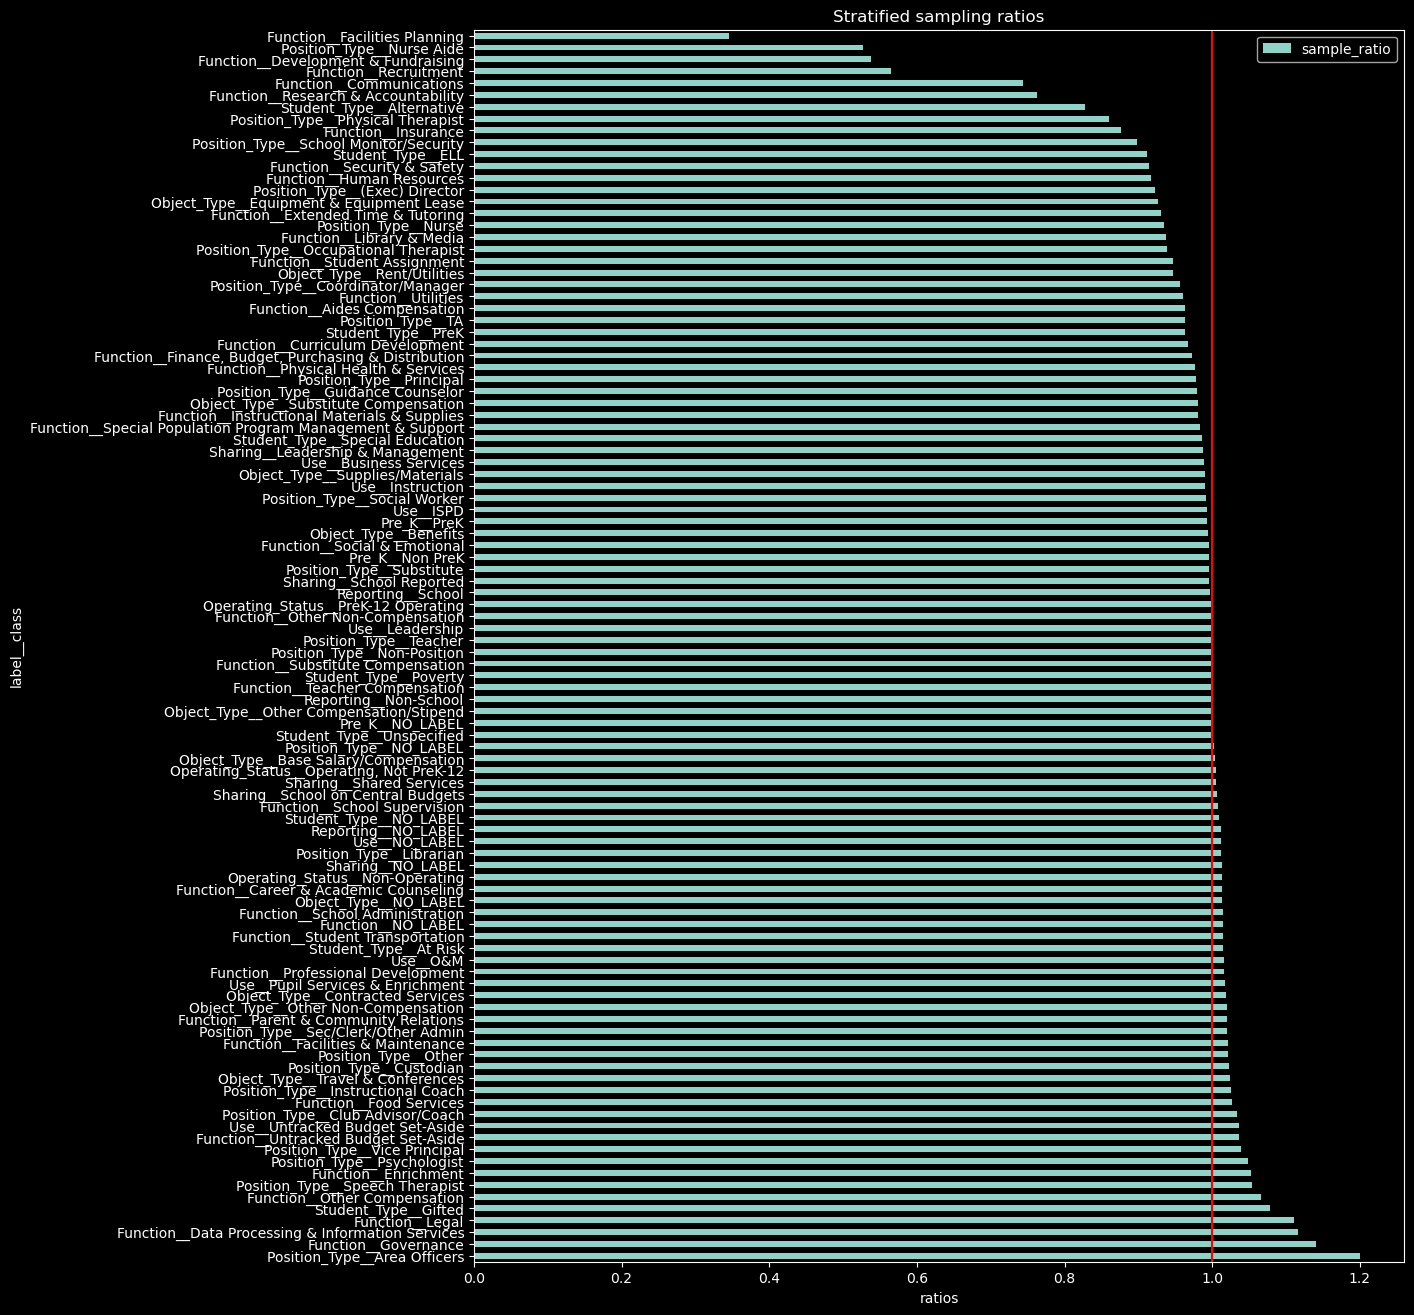

,sample_ratio
label__class,
Function__Facilities Planning,0.344834
Position_Type__Nurse Aide,0.526325
Function__Development & Fundraising,0.537644
Function__Recruitment,0.565312
Function__Communications,0.743256
...,...
Student_Type__Gifted,1.078389
Function__Legal,1.111131
Function__Data Processing & Information Services,1.116959


In [140]:
sampling = multilabel_sample_dataframe(df,
                                       y,
                                       size=0.1, #0.01
                                       min_count=0, #7,
                                       seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
print('Sample size:', sampling.shape[0])
sample_report(y, dummy_labels, figsize=(12,16))

## Stratified split of the stratified sample

Sample size: 40027
Train size`: 36025
Test size  : 4002


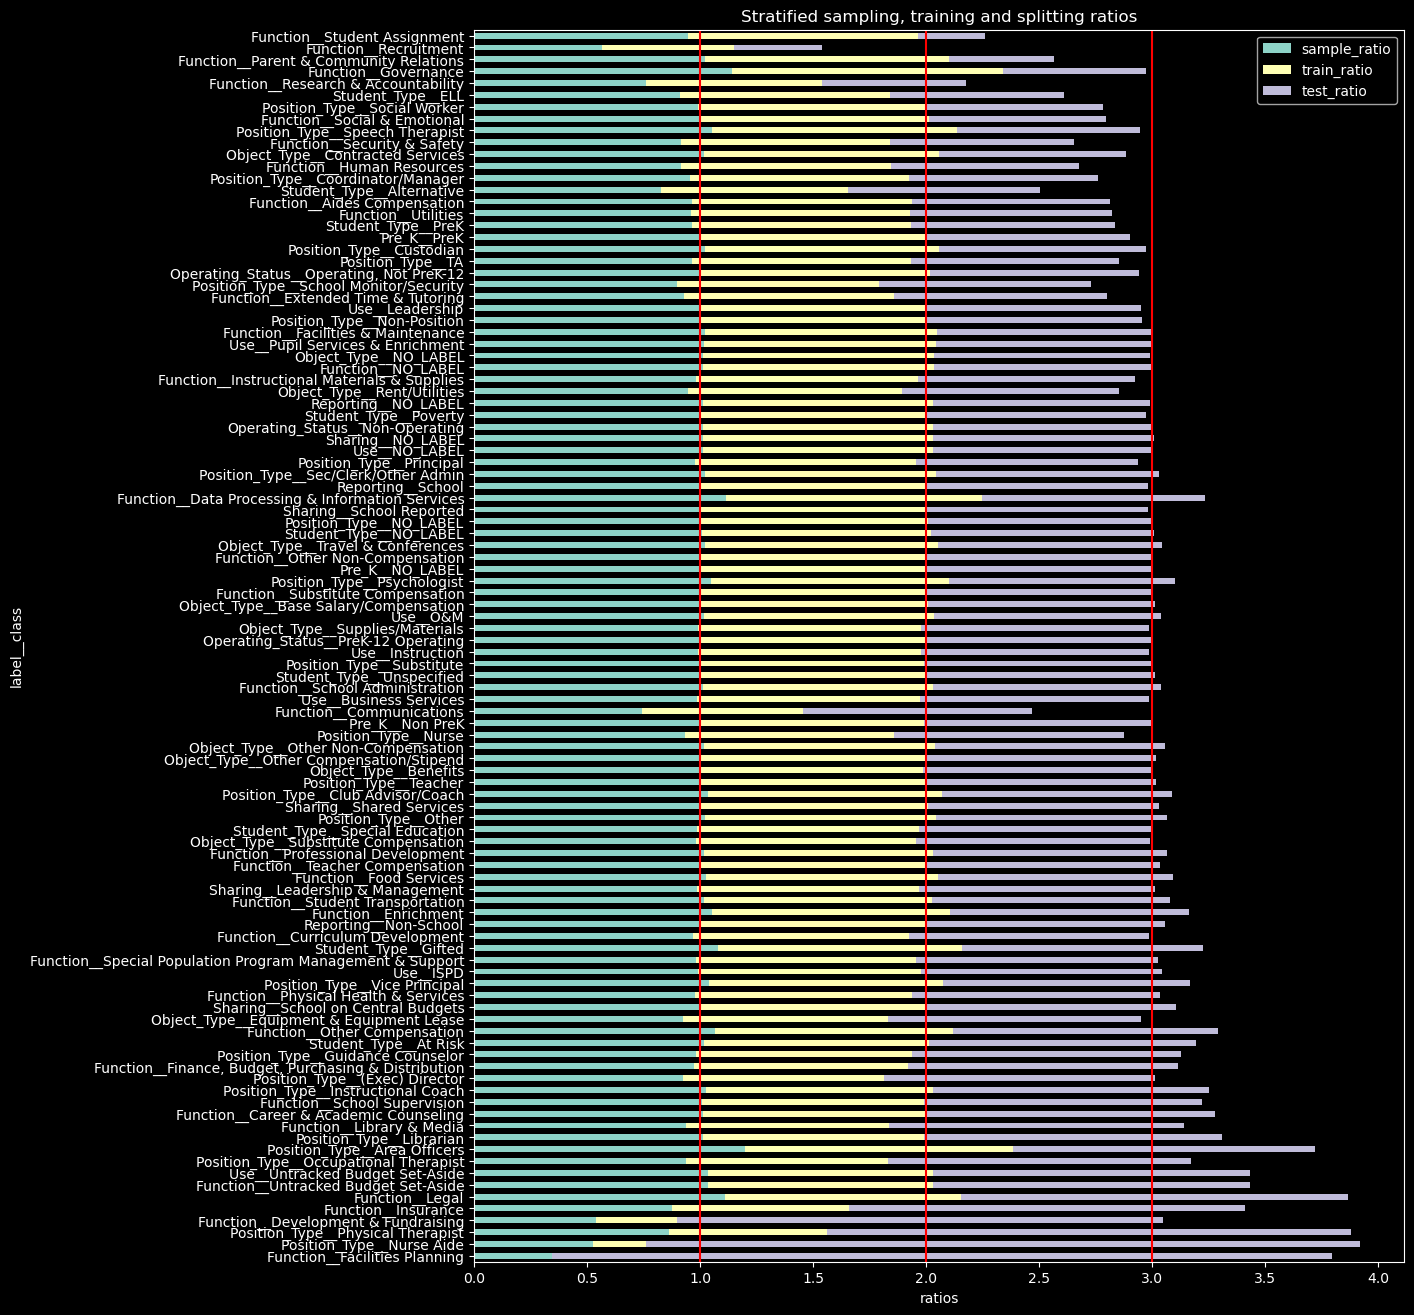

,sample_ratio,train_ratio,test_ratio
label__class,,,
Function__Student Assignment,0.946762,1.019064,0.295915
Function__Recruitment,0.565312,0.584794,0.389939
Function__Parent & Community Relations,1.019953,1.081747,0.463696
Function__Governance,1.141066,1.197392,0.634036
Function__Research & Accountability,0.762725,0.776835,0.635716
...,...,...,...
Function__Insurance,0.877208,0.779726,1.754724
Function__Development & Fundraising,0.537644,0.358422,2.150951
Position_Type__Physical Therapist,0.860942,0.699042,2.318327


In [144]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES],
                                                               dummy_labels,
                                                               size=0.1,
                                                               min_count=1,
                                                               seed=1)
print('Sample size:', sampling.shape[0])
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])
sample_split_report(y, dummy_labels, y_train, y_test, figsize=(12,16))

Here we see that some testing labels are missing after splitting.  
It's required to simultaneously optimize the `size` and `min_count` parameters on either `multilabel_sample_dataframe` and `multilabel_train_test_split`, thus, balancing the stratification the best possible to achieve the best ratio.

# Optimize sampling and splitting parameters

Run the script `optimize-sample-split.py` to prepare data for analysis

In [ ]:
import pickle
if os.path.isfile('/data/drivendata/optimize-sample-split.pkl'):
    with open('/data/drivendata/optimize-sample-split.pkl', 'rb') as f:
        results = pickle.load(f)
else:
    print('Please run the optimize-sample-split.py')
    exit

# Drop rows containing NaN or Infinite
print('original', results.shape)
results = results.replace([np.inf, -np.inf], np.nan).dropna()
print('after drop nan/inf', results.shape)

# Convert ratios to indices starting from zero
results['sample_index'] = np.abs(results.sample_ratio - 1)
results['train_index'] = np.abs(results.train_ratio - 1)
results['test_index'] = np.abs(results.test_ratio - 1)

# Best parameters decision

* For begining the model, the parameter set should result in:
    * The smallest sample size (e.g. 0.1)
    * The smallest test size (e.g. 0.1)
    * The best stratified sample (sample_index) and split (train_index and test_index)
* For finishing the model, the parameter set should have:
    * The full dataset with not stratify intervention (sample size 1.0 sample min count 0)
    * The smallest test size (e.g. 0.1)
    * The best stratified split (train_index and test_index)
    * The minimum stratify intervention (split min count ~0)
* Both parameter sets should support a minimum of the desired k classes for `GridSearchCV`/`StratifedKFold`
* The k-folding is limited by the population less frequent class:
    * The train less frequent class should at least k.
    * The test less frequent class should at least 1.
    * The sample less frequent class is implied to at least k+1.

## For begining the model

At desired k-folds, smallest sample, 20% test size, best indices

In [ ]:
results

In [ ]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

At desired k-folds, 10% sample size, 20% test sizes, best indices

In [ ]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.sample_size==0.1) & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

At max k folds, smallest sample size, 20% test size, best indices

In [ ]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

At max k folds, 10% sample size, 20% test size, best indices

In [ ]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.sample_size==0.1) & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

## For finishing the model

At desired k-folds, 100% data with no stratify intervention, 20% test size with mininum stratify intervention and best indices

In [ ]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) &
        (results.sample_size==1) & (results.sample_min_count==0) & (results.test_size >= .2)
       ].sort_values(['test_size', 'test_min_count', 'train_index', 'test_index']
                    )[['test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

At max k-folds, 100% data with no stratify intervention, 20% test size with mininum stratify intervention and best indices

In [ ]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) &
        (results.sample_size==1) & (results.sample_min_count==0) & (results.test_size >= .2)
       ].sort_values(['test_size', 'test_min_count', 'train_index', 'test_index']
                    )[['test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)